In [1]:
#from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *
from libs.convex_hull import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from libs.InteractivePitchUI import InteractivePitch, PitchDisplay

from mplsoccer import *
import pandas as pd
import numpy as np
import os
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


In [2]:
# Step 1: Extract match data from tracking data
data = compile_team_tracking_data("data/H_EURO2024GERMANY", "England")
one_match = extract_one_match(data, 4)


In [3]:
print(np.unique(one_match['match_name']))

['Denmark_England' 'England_Slovakia' 'England_Slovenia'
 'England_Switzerland']


In [4]:
import os
import json
import re
import numpy as np
import pandas as pd
from libs.Video_Player import *

def extract_metadata(file_path):
    """Load and return data from a JSON file."""
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)

def extract_half_start(data):
    """Extract and convert start times of the first and second half into seconds."""
    first_half_start = data["halvesTimestamps"]["1H"]["startTime"]
    second_half_start = data["halvesTimestamps"]["2H"]["startTime"]
    first_half_end = data["halvesTimestamps"]["1H"]["endTime"]

    # Convert HH:MM:SS to total seconds
    def time_to_seconds(time_str):
        h, m, s = map(int, time_str.split(":"))
        return h * 3600 + m * 60 + s

    return time_to_seconds(first_half_start), time_to_seconds(second_half_start), time_to_seconds(first_half_end)

def find_files(match_folder):
    """Finds the .json and .mp4 files in the match folder."""
    json_file, video_file = None, None

    for file in os.listdir(match_folder):
        if file.endswith(".json"):
            json_file = os.path.join(match_folder, file)
        elif file.endswith(".mp4"):
            video_file = os.path.join(match_folder, file)

    if not json_file or not video_file:
        raise FileNotFoundError("Required .json or .mp4 file missing in the folder.")

    return json_file, video_file

def find_match_folder(tournament_folder, match_name):
    """
    Finds the correct match folder inside the tournament folder.
    Match folders contain numbers (e.g., '2036178_Denmark_England'),
    so we search for a folder that contains 'match_name'.
    """
    for folder in os.listdir(tournament_folder):
        if match_name in folder:
            return os.path.join(tournament_folder, folder)
    
    raise FileNotFoundError(f"Match folder for '{match_name}' not found in '{tournament_folder}'")

def process_match_data(tournament_folder, raw_match_name):
    """
    Given the tournament folder and match name from the DataFrame,
    locate the correct match folder, extract halves' start times, and find the video.
    """
    match_folder = find_match_folder(tournament_folder, raw_match_name)
    
    # Find JSON and MP4 files dynamically
    json_file, video_file = find_files(match_folder)

    # Extract data from JSON
    data = extract_metadata(json_file)
    first_half_start, second_half_start, first_half_end = extract_half_start(data)

    return {
        "match_folder": match_folder,
        "json_file": json_file,
        "video_file": video_file,
        "first_half_start": first_half_start,
        "second_half_start": second_half_start,
        "first_half_end" : first_half_end
    }

# **Optimized function to process only unique match names**
def process_dataframe(df, tournament_folder):
    """Processes each unique match in the DataFrame to extract JSON and video details."""
    results = []
    
    unique_match_names = df['match_name'].drop_duplicates().tolist()  # Extract unique match names

    for match_name in unique_match_names:
        print(f"Processing match: {match_name}")
        try:
            match_data = process_match_data(tournament_folder, match_name)
            results.append(match_data)
            # Append the match name to results
            results[-1]["match_name"] = match_name
        except FileNotFoundError as e:
            print(f"Error processing match {match_name}: {e}")
    return pd.DataFrame(results)

# Example usage:
tournament_folder = "data/H_EURO2024GERMANY"

processed_data = process_dataframe(one_match, tournament_folder)

def display_match_info(df):
    """Displays match information in a structured format."""
    if df.empty:
        print("No valid match data found.")
        return

    print("\n=========== Processed Match Data ===========")
    
    for i, row in df.iterrows():
        print(f"\nMatch Folder: {row['match_folder']}")
        print(f"Folder Name: {os.path.basename(row['match_folder'])}\n")
        print(f"Match Name: {row['match_name']}\n")

        print(f"JSON File: {row['json_file']}")
        print(f"JSON Name: {os.path.basename(row['json_file'])}\n")

        print(f"Video File: {row['video_file']}")
        print(f"Video Name: {os.path.basename(row['video_file'])}\n")

        print(f"First Half Start: {row['first_half_start']} seconds")
        print(f"Second Half Start: {row['second_half_start']} seconds")
        print("=" * 50)  # Separator line

# Example usage:
display_match_info(processed_data)

# Extracting video details for playback
#for _, row in processed_data.iterrows():
#    video_file = row["video_file"]
#    video_name = os.path.basename(video_file)
#    first_half_start = row["first_half_start"]
#    second_half_start = row["second_half_start"]
#    print(second_half_start)
#    example_indices = np.array([[0, '1H'], [0, '2H']])#

#    # Launch Video Player
#    VideoPlayer(video_file, video_name, first_half_start, second_half_start, example_indices)
#    

Processing match: Denmark_England
Processing match: England_Slovenia
Processing match: England_Slovakia
Processing match: England_Switzerland

=========== Processed Match Data ===========

Match Folder: data/H_EURO2024GERMANY\2036178_Denmark_England
Folder Name: 2036178_Denmark_England

Match Name: Denmark_England

JSON File: data/H_EURO2024GERMANY\2036178_Denmark_England\DEN - ENG.json
JSON Name: DEN - ENG.json

Video File: data/H_EURO2024GERMANY\2036178_Denmark_England\3-2024-2036178-Denmark_England.mp4
Video Name: 3-2024-2036178-Denmark_England.mp4

First Half Start: 9 seconds
Second Half Start: 3751 seconds

Match Folder: data/H_EURO2024GERMANY\2036189_England_Slovenia
Folder Name: 2036189_England_Slovenia

Match Name: England_Slovenia

JSON File: data/H_EURO2024GERMANY\2036189_England_Slovenia\SRB - ENG.json
JSON Name: SRB - ENG.json

Video File: data/H_EURO2024GERMANY\2036189_England_Slovenia\3-2024-2036200-England_Slovakia.mp4
Video Name: 3-2024-2036200-England_Slovakia.mp4

Fir

In [5]:
print(processed_data.columns)

Index(['match_folder', 'json_file', 'video_file', 'first_half_start',
       'second_half_start', 'first_half_end', 'match_name'],
      dtype='object')


In [6]:
def show_reccomendations(processed_video_info, match_data : pd.DataFrame, indices):
    relevant_rows = match_data.loc[indices]
    print(relevant_rows)
    
    for index, data in relevant_rows.iterrows():
        print(data)

        meta_data = processed_video_info[processed_video_info["match_name"] == data['match_name']].iloc[0]
        
      
        indices = [data[["Time [s]","half"]].to_numpy()]
        print(indices)
        video_file = meta_data["video_file"]
        print(meta_data['video_file'])
        video_name = os.path.basename(video_file)
        first_half_start = meta_data["first_half_start"]
        second_half_start = meta_data["second_half_start"]
        first_half_end = meta_data["first_half_end"]
        if (video_name):
            VideoPlayer(video_file, video_name, first_half_start,first_half_end, second_half_start, indices)
    



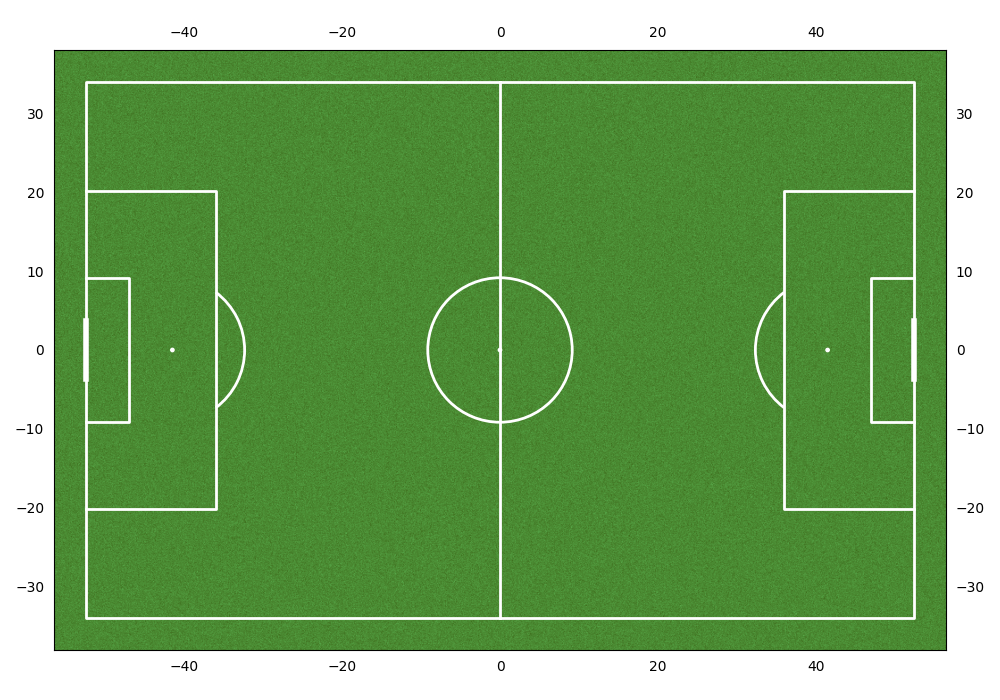

Ball placement mode enabled. Click to place the ball on the pitch.
Ball placed at: (np.float64(13.345458914515717), np.float64(25.043893242143696))
Vector drawing mode enabled. Select start and end points for the vector.
Situation saved! Total saved situations: 1
Cleared the current situation. All players are available for selection again.
Loaded Situation 1
10992
           home_1_x  home_1_y   home_2_x   home_2_y  home_3_x  home_3_y  \
home_1_x  39.951912  0.337901  14.105643  25.043893  17.65317  9.586811   
home_1_y  39.951912  0.337901  14.105643  25.043893  17.65317  9.586811   
home_2_x  39.951912  0.337901  14.105643  25.043893  17.65317  9.586811   
home_2_y  39.951912  0.337901  14.105643  25.043893  17.65317  9.586811   
home_3_x  39.951912  0.337901  14.105643  25.043893  17.65317  9.586811   

           home_4_x   home_4_y   home_5_x  home_5_y  ...   home_8_x  home_8_y  \
home_1_x  10.051327 -12.711931  11.318301 -26.39525  ... -14.021179  3.758731   
home_1_y  10.051327 

In [ ]:

%matplotlib widget

one_match = one_match[one_match['match_name'] != 'England_Slovenia']

interactive_pitch = InteractivePitch(one_match)


In [9]:
show_reccomendations(processed_data, interactive_pitch.match_data, interactive_pitch.similar_situation_indices[:5])

        match_id  Time [s]  Time [s]_team half_team  minute_team  Period_team  \
202692         1   2327.04        2327.04        1H           38            1   
458256         3   1249.64        1249.64        1H           20            1   
200148         1   2225.28        2225.28        1H           37            1   
469440         3   1697.00        1697.00        1H           28            1   
223812         1   3104.20        3104.20        2H           51            2   

         home_6_x   home_6_y   home_1_x  home_1_y  ...  home_24_x  home_24_y  \
202692  31.116207   7.871012  46.807320  1.469006  ...        NaN        NaN   
458256  10.370897  22.843065  24.428432  3.265418  ...        NaN        NaN   
200148  31.373436   6.219526  46.231438  0.750499  ...        NaN        NaN   
469440   8.705735  26.079487  31.482908  4.083295  ...        NaN        NaN   
223812  22.678215  -9.023755  33.727196  2.781324  ...        NaN        NaN   

        home_17_x  home_17_y  ho